<a href="https://colab.research.google.com/github/SamuelXJames/Auto-Music-Seperation/blob/main/preprocessing/preprocess_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess Images

This code creates patches out the LR and HR images and stores them in TF Records. The LR images are a blurred version of the HR that have yet to be downsized. If blurred images are not being used than the LR directory can be the same as the HR directory. 

## Connect to Google Cloud Storage (GCS)

The images are stored on a GCS bucket. Alternatively, they can be stored locally or on Google Drive 



In [ ]:
## IGNORE if storing kerenels locally or on Google Drive
#Authenticare access to cloud storage
!gcloud auth login

#Set current GCS project
!gcloud config set project superres000

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=m6noqyoYudrc8815lWEigUq5FwWxaZ&prompt=consent&access_type=offline&code_challenge=bD2CpkmijmR0AWFiceJPpcjF_4sexbIPeKYGgR1L-BE&code_challenge_method=S256

Enter verification code: 4/1AY0e-g7QRazBIfKH66bbDcnJW-3dGIpqTAblUInJO4yCD9qfIhYUk3lZkhs

You are now logged in as [jameskl1997@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].


In [ ]:
## IGNORE if storing kerenels locally or on Google Drive
#Setup google cloud sdk (seems to be necessary but could be redudant)
from google.colab import auth
auth.authenticate_user()

## Import Libraries 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
import os, sys, math, glob, ntpath,time
from PIL import Image
from datetime import timedelta
from tqdm.notebook import tqdm


## Create Local Directories

Patches are stored locally to save time

In [ ]:
!mkdir "HR Patches"
!mkdir "LR Patches"

## Collect HR and LR Images

Lists the HR and LR filenames

In [ ]:
# Directories
#HR_DIR = 'gs://super_res_train/Test/Valid/'
#LR_DIR = 'gs://super_res_train/Test/x4/'
HR_DIR = '/content/HR/'
LR_DIR = '/content/LR/'

HR_PATCH_DIR = '/content/HR Patches/'
LR_PATCH_DIR = '/content/LR Patches/'
img_format = '*.png'

# Get Filenames and pair HR and LR files
HR_files = tf.io.gfile.glob(HR_DIR + img_format)
LR_files = tf.io.gfile.glob(LR_DIR + img_format)

# Number of Images
num_HR = len(HR_files) 
num_LR = len(LR_files)
print('Number of HR Images {}'.format(num_HR))
print('Number of LR Images {}'.format(num_LR))


Number of HR Images 3
Number of LR Images 3


## Check Image Size
Confirms the LR and HR images have the same shape



In [ ]:
def check_img_shape(HR_filenames,LR_filenames):
  print('Mismatched Images')
  print('HR File' + '\t\t' + 'LR File' + '\t\t' + 'HR Shape' + '\t\t' + 'LR Shape')
  valid = True
  for (HR,LR) in zip(HR_filenames,LR_filenames):
    HR_size = np.shape(tf.image.decode_png(tf.io.read_file(HR)))
    LR_size = np.shape(tf.image.decode_png(tf.io.read_file(LR)))

    
    if HR_size != LR_size:
      valid = False
      _,HR = ntpath.split(HR)
      _,LR = ntpath.split(LR)
      print(HR + '\t' + LR + '\t' + str(HR_size) + '\t\t' + str(LR_size))
    
  if valid == True:
    print('The shape of all LR and HR images match')
  return None

check_img_shape(HR_files,LR_files)


Mismatched Images
HR File		LR File		HR Shape		LR Shape
The shape of all LR and HR images match


## Create Patches
@author: Francesco Cardinale et al. 
https://github.com/idealo/image-super-resolution

  Patches are stored locally rather than GCS. This speeds up the process >100x
          

In [ ]:

def patch_images(filename,folder,patch_size = 80,padding_size=2,downsample = None,
                 method = None):
    '''
    downsample: the downsampling factor if the images are LR images (eg. 4)
    method: 'bicubic' or 'real' if using realistically blurred LR images
    '''
       
    # Read Image
    image_array = tf.io.read_file(filename)
    image_array = tf.image.decode_png(image_array)
    
    # Filenaming: img#_patch#.png
    _,filename = ntpath.split(filename)
    filename = os.path.splitext(filename)[0]
    count = 0

    xmax, ymax, _ = image_array.shape
    x_remainder = xmax % patch_size
    y_remainder = ymax % patch_size
    
    # modulo here is to avoid extending of patch_size instead of 0
    x_extend = (patch_size - x_remainder) % patch_size
    y_extend = (patch_size - y_remainder) % patch_size
    
    # make sure the image is divisible into regular patches
    extended_image = np.pad(image_array, ((0, x_extend), (0, y_extend), (0, 0)), 'edge')
    
    # add padding around the image to simplify computations
    padded_image = pad_patch(extended_image, padding_size, channel_last=True)
    
    xmax, ymax, _ = padded_image.shape
    patches = []
    
    x_lefts = range(padding_size, xmax - padding_size, patch_size)
    y_tops = range(padding_size, ymax - padding_size, patch_size)
    
    for x in x_lefts:
        for y in y_tops:
            x_left = x - padding_size
            y_top = y - padding_size
            x_right = x + patch_size + padding_size
            y_bottom = y + patch_size + padding_size
            patch = padded_image[x_left:x_right, y_top:y_bottom, :]
            patch_name = '{}_{:04d}.png'.format(filename,count,downsample)
            
            
            if downsample != None:
              patch_name = '{}_{:04d}x{}.png'.format(filename,count,downsample)
              if method == 'bicubic':
                patch = Image.fromarray(patch)
                patch = patch.resize((np.floor(patch_size/downsample),
                                      np.floor(patch_size/downsample)))
              elif method == 'real':
                patch = patch[::downsample,::downsample]
                patch = Image.fromarray(patch)
                
              elif method == None:
                print('No method specified')
                return None
            
            else:
              patch = Image.fromarray(patch)
            
            count = count + 1
            
            patch_path = os.path.join(folder,patch_name)
            
            patch.save(patch_path)
            
    
    return None

def pad_patch(image_patch, padding_size, channel_last=True):
    """ Pads image_patch with with padding_size edge values. """
    
    if channel_last:
        return np.pad(
            image_patch,
            ((padding_size, padding_size), (padding_size, padding_size), (0, 0)),
            'edge',
        )
    else:
        return np.pad(
            image_patch,
            ((0, 0), (padding_size, padding_size), (padding_size, padding_size)),
            'edge',
        )
    
    return None


for (HR,LR) in tqdm(zip(HR_files,LR_files)):
  patch_images(HR,HR_PATCH_DIR)
  patch_images(LR,LR_PATCH_DIR,downsample = 4,method = 'real')



## Sanity Check
Confirm patches





In [ ]:
def check_img_patches(HR_filenames,LR_filenames):
  print('Info on patches')
  print('Number of HR Patches {}'.format(len(HR_filenames)))
  print('Number of LR Patches {}'.format(len(LR_filenames)))

  HR_shape = np.shape(tf.image.decode_png(tf.io.read_file(HR_filenames[0])))
  LR_shape = np.shape(tf.image.decode_png(tf.io.read_file(LR_filenames[0]))) 
  
  print('HR Shape: {}'.format(HR_shape))
  print('LR Shape: {}'.format(LR_shape))
  '''
  #Uncomment to verify that the shape of all patches are consistant 
  print('Mismatched Images')
  print('HR File' + '\t\t' + 'LR File' + '\t\t' + 'HR Shape' + '\t\t' + 'LR Shape')
  valid = True
  for (HR,LR) in zip(HR_filenames,LR_filenames):
    HR_size = np.shape(tf.image.decode_png(tf.io.read_file(HR)))
    LR_size = np.shape(tf.image.decode_png(tf.io.read_file(LR)))

    
    if HR_size != HR_shape or LR_size != LR_shape:
      valid = False
      _,HR = ntpath.split(HR)
      _,LR = ntpath.split(LR)
      print(HR + '\t' + LR + '\t' + str(HR_size) + '\t\t' + str(LR_size))
    
  if valid == True:
    print('The shape of all LR and HR images match')

  '''
  return None

HR_patches = sorted(glob.glob(HR_PATCH_DIR+img_format))
LR_patches = sorted(glob.glob(LR_PATCH_DIR+img_format))
check_img_patches(HR_patches,LR_patches)



Info on patches
Number of HR Patches 4030
Number of LR Patches 4030
HR Shape: (84, 84, 3)
LR Shape: (21, 21, 3)


## View Images

Top: HR
Bottom: LR
Filenames
0021_1927.png	0021_1927x4.png
0021_1101.png	0021_1101x4.png
0021_0130.png	0021_0130x4.png
0022_0580.png	0022_0580x4.png
0023_0080.png	0023_0080x4.png


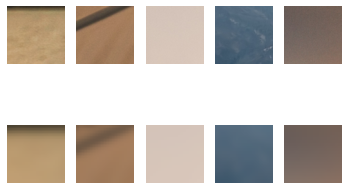

In [ ]:
# View some of the images
sample = np.random.randint(int(len(HR_patches)-1),size = 5)
count = 1
images = []
print('Top: HR\nBottom: LR')
print('Filenames')


for val in sample:
  plt.subplot(2,5,count)
  HR_file = HR_patches[val]
  HR_image = tf.io.read_file(HR_file)
  HR_image = tf.image.decode_png(HR_image)
  plt.imshow(HR_image)
  plt.axis('off')
  count = count+1
  _,HR_name = ntpath.split(HR_file)
  

  plt.subplot(2,5,count+4)
  LR_file = LR_patches[val]
  LR_image = tf.io.read_file(LR_file)
  LR_image = tf.image.decode_png(LR_image)
  plt.imshow(LR_image)
  plt.axis('off')
  _,LR_name = ntpath.split(LR_file)
  print(HR_name+ '\t'+LR_name)
  


## Create TF Dataset

In [ ]:
# Read files
def decode_png_and_label(filename):
  HR_filename = filename[0]
  LR_filename = filename[1]

  HR_image = tf.io.read_file(HR_filename)

  LR_image = tf.io.read_file(LR_filename)
  
  HR_label = tf.strings.split(tf.expand_dims(HR_filename, axis=-1), sep='/')
  HR_label = HR_label.values[-1]

  LR_label = tf.strings.split(tf.expand_dims(LR_filename, axis=-1), sep='/')
  LR_label = LR_label.values[-1]
  return HR_image, HR_label, LR_image, LR_label

# Collect LR and HR Patch filenames and add to dataset
files = [val for pair in zip(HR_patches,LR_patches) for val in pair]
files = np.reshape(files,(-1,2),order = 'C')

AUTO = tf.data.experimental.AUTOTUNE
dataset = tf.data.Dataset.from_tensor_slices(files)


# Add Files to the TF Dataset
dataset = dataset.map(decode_png_and_label,num_parallel_calls=AUTO)



## Confrim Dataset

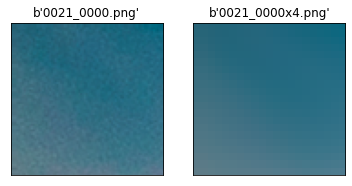

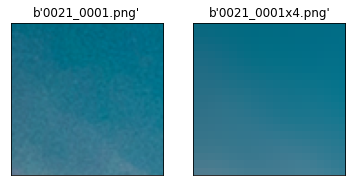

In [ ]:
# Confirm Labels
for (HR_image,HR_label,LR_image,LR_label) in dataset.take(2):
  plt.figure()
  plt.subplot(121)
  plt.imshow(tf.image.decode_png(HR_image))
  plt.xticks([])
  plt.yticks([])
  plt.title(HR_label.numpy())
  plt.subplot(122)
  plt.imshow(tf.image.decode_png(LR_image))
  plt.xticks([])
  plt.yticks([])
  plt.title(LR_label.numpy())
  
  
  

In [ ]:
for (HR_image,HR_label,LR_image,LR_label) in dataset.take(10):
  print('HR Shape: {}, LR Shape: {}, Image Type: {}, Label Type: {}'.format(np.shape(tf.image.decode_png(HR_image)),
                                                                            np.shape(tf.image.decode_png(LR_image)),
                                                                            type(HR_image.numpy()),
                                                                            type(HR_label.numpy())))
                                            
                                                     

HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>, Label Type: <class 'bytes'>
HR Shape: (84, 84, 3), LR Shape: (21, 21, 3), Image Type: <class 'bytes'>

## TF Record Config.

In [ ]:
#GCS_OUTPUT = 'gs://super_res_train/Test/TFRecords/'
GCS_OUTPUT = '/content/'

#images per TF Record shard
img_shard = 1000

num_shards = len(LR_patches)/img_shard
if num_shards != np.floor(num_shards):
  excess = len(LR_patches) % img_shard
  num_shards = np.floor(num_shards)
else:
  excess = 0
  
print('Shards: {}\nExcess Images: {}'.format(num_shards,excess))

# Shuffle and Batch Dataset
#dataset = dataset.shuffle(1,reshuffle_each_iteration = True)
dataset2 = dataset.batch(img_shard, drop_remainder=False)

Shards: 4.0
Excess Images: 30


## Write dataset to a TF Record

In [ ]:
# Writes TFDataset to a TF Record
def writeTFRecord(writer,HR,HR_label,LR,LR_label):
  example = tf.train.Example(features=tf.train.Features(feature={
        'HR': tf.train.Feature(bytes_list=tf.train.BytesList(value=[HR])),
        'HR_label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[HR_label])),
    
        'LR': tf.train.Feature(bytes_list=tf.train.BytesList(value=[LR])),
        'LR_label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[LR_label]))
        
        
    }))
  
  return example


#Write TF Records
options = tf.io.TFRecordOptions(compression_type = 'ZLIB',
                                compression_level = 9)
                                
for shard,(HR,HR_label,LR,LR_label) in enumerate(dataset2):
  filename = GCS_OUTPUT + '{:02d}_{}_SRImages.tfrec'.format(shard,img_shard)
  shard_size = HR.numpy().shape[0]
  with tf.io.TFRecordWriter(filename, options = options) as out_file:
    for i in range(shard_size):
      example = writeTFRecord(out_file,
                              HR.numpy()[i],
                              HR_label.numpy()[i],
                              LR.numpy()[i],
                              LR_label.numpy()[i])
      out_file.write(example.SerializeToString())
    print('Completed: {}/{} Wrote File: {}'.format(shard+1,int(num_shards),filename))
  
  


Completed: 1/4 Wrote File: /content/00_1000_SRImages.tfrec
Completed: 2/4 Wrote File: /content/01_1000_SRImages.tfrec
Completed: 3/4 Wrote File: /content/02_1000_SRImages.tfrec
Completed: 4/4 Wrote File: /content/03_1000_SRImages.tfrec
Completed: 5/4 Wrote File: /content/04_1000_SRImages.tfrec


## Read the TFRecrods

In [ ]:
# Select TFRrecord to read
AUTO = tf.data.experimental.AUTOTUNE
img_shard = 1000
GCS_File = '/content/00_1000_SRImages.tfrec'
dataset3 = tf.data.TFRecordDataset(GCS_File,  compression_type='ZLIB',
                                   num_parallel_reads=AUTO)
nb_images = img_shard
HR_IMG_SHAPE = [84,84]
LR_IMG_SHAPE = [21,21]
NUM_CHANNELS = 3


def read_tfrecord(example):
# Create a dictionary describing the features.
  features = {
      'HR': tf.io.FixedLenFeature([], tf.string),
      'HR_label': tf.io.FixedLenFeature([], tf.string),
      'LR': tf.io.FixedLenFeature([], tf.string),
      'LR_label': tf.io.FixedLenFeature([], tf.string)
  }
  
  example = tf.io.parse_single_example(example, features)

  HR = tf.io.decode_png(example['HR'])
  HR = tf.reshape(HR, [HR_IMG_SHAPE[0],HR_IMG_SHAPE[1], NUM_CHANNELS])

  LR = tf.io.decode_png(example['LR'])
  LR = tf.reshape(LR, [LR_IMG_SHAPE[0],LR_IMG_SHAPE[1], NUM_CHANNELS])
  
  HR_label = example['HR_label']
  LR_label = example['LR_label']
  
  return HR,HR_label,LR,LR_label

dataset3 = dataset3.map(read_tfrecord)
for (HR_image,HR_label,LR_image,LR_label) in dataset3.take(1):
  print('HR Shape: {}, LR Shape: {}'.format(np.shape(HR_image),np.shape(LR_image)))


   
   






HR Shape: (84, 84, 3), LR Shape: (21, 21, 3)


## View TF Records

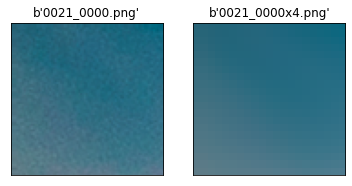

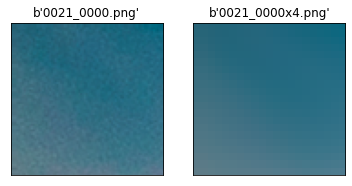

In [ ]:
#Number of each image to show
img_num = [1,2]

for (HR_image,HR_label,LR_image,LR_label) in dataset3.take(1):
  for i in img_num:
    plt.figure()
    plt.subplot(121)
    plt.imshow(HR_image[:,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(HR_label.numpy())
    plt.subplot(122)
    plt.imshow(LR_image[:,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(LR_label.numpy())
  